# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2020

Мягкий дедлайн: 23:59MSK 10.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2020

Максимальная оценка: 9.11

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей (2 + 0.5 балла). 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=1/7, random_state=402)

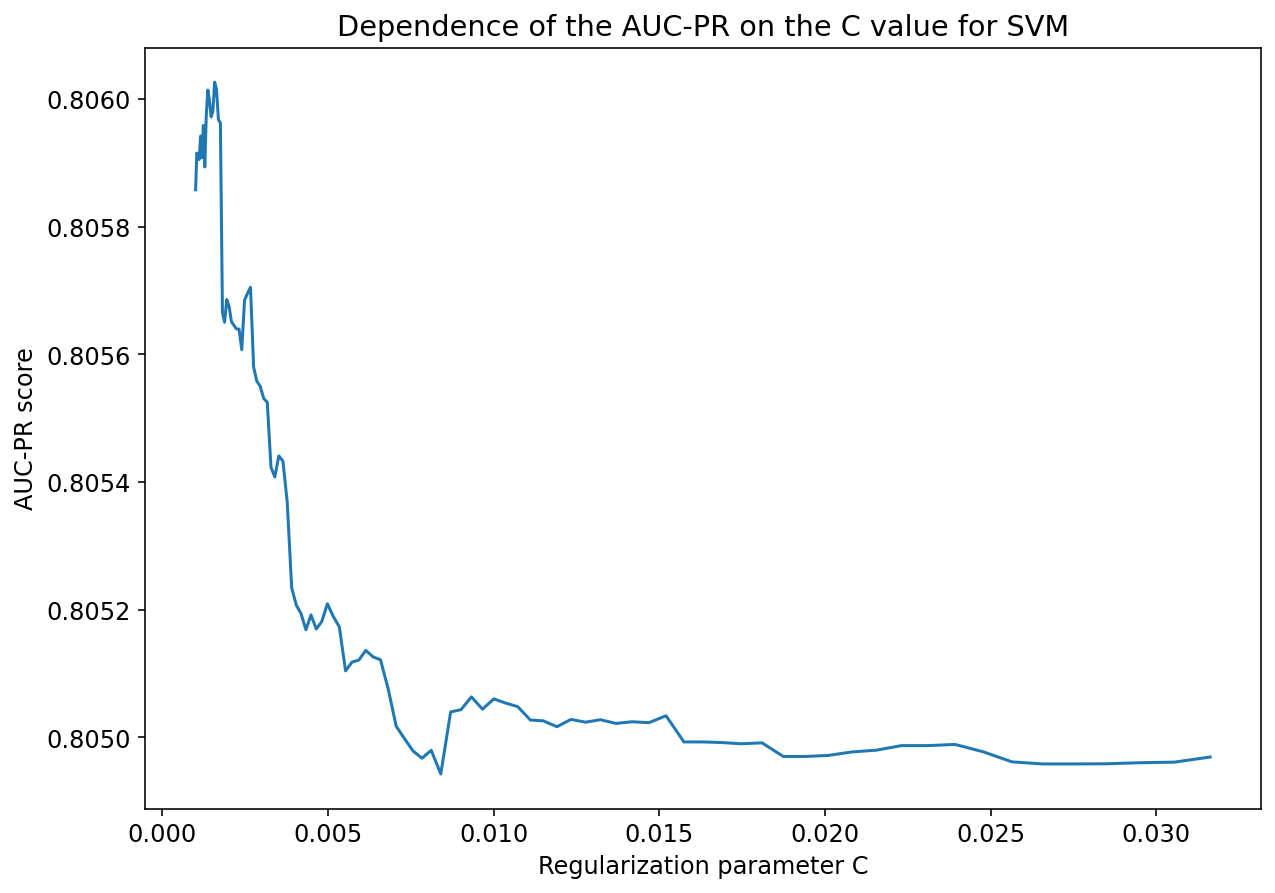

In [5]:
Cs = np.logspace(-3, -1.5, 100, base=10)
cs_dict = dict()

for C in Cs:
    svm = make_pipeline(StandardScaler(), LinearSVC(C=C, max_iter=10000))
    svm.fit(X_train, y_train)
    y_proba = svm.decision_function(X_val)
    precision, recall, _ = precision_recall_curve(y_val, y_proba, pos_label=1)
    cs_dict[C] = auc(recall, precision)


plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 12
plt.plot(list(cs_dict.keys()), list(cs_dict.values()))
plt.xlabel("Regularization parameter C")
plt.ylabel("AUC-PR score")
plt.title('Dependence of the AUC-PR on the C value for SVM')
plt.show()

In [6]:
C_best = list(cs_dict.keys())[np.argmax(np.array(list(cs_dict.values())))]

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [7]:
from sklearn.metrics import roc_curve

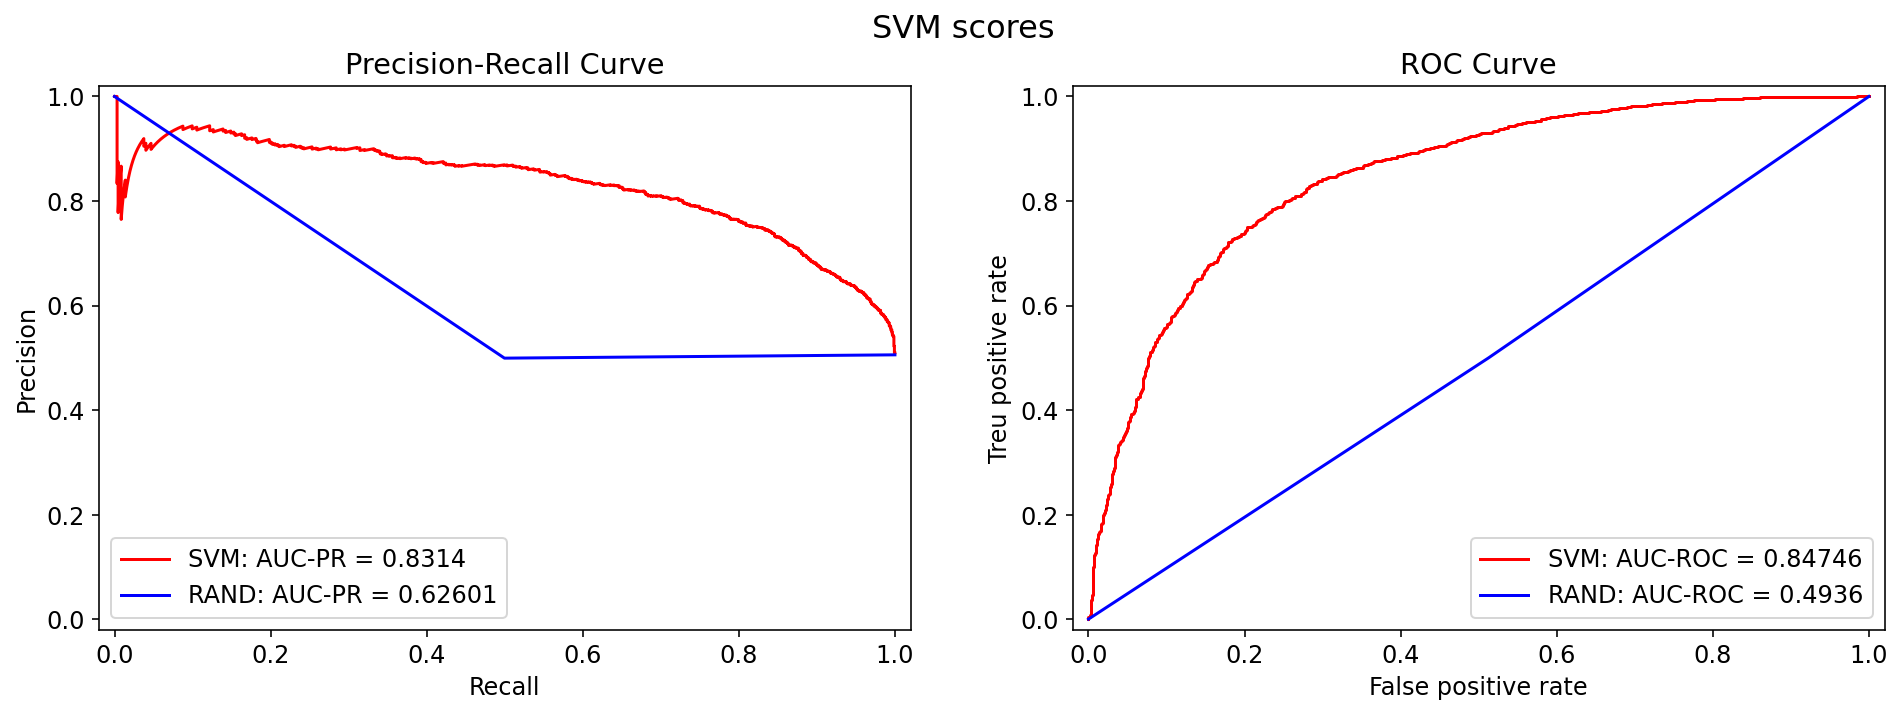

In [8]:
svm = make_pipeline(StandardScaler(), LinearSVC(C=C_best, max_iter=10000))

# значения метрик для классификатора
svm.fit(X_train, y_train)
y_proba = svm.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)
fpr, tpr, __ = roc_curve(y_test, y_proba, pos_label=1)
auc_pr = round(auc(recall, precision), 5)
auc_roc = round(auc(fpr, tpr), 5)

# значения метрик для случайного классификатора
y_rand = np.random.choice([0, 1], size=y_test.shape[0], p=[0.5, 0.5])
precision_r, recall_r, _ = precision_recall_curve(y_test, y_rand, pos_label=1)
fpr_r, tpr_r, __ = roc_curve(y_test, y_rand, pos_label=1)
auc_pr_rand = round(auc(recall_r, precision_r), 5)
auc_roc_rand = round(auc(fpr_r, tpr_r), 5)

# графики
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('SVM scores', fontsize=16)

axs[0].plot(recall, precision, 'r', label=f"SVM: AUC-PR = {auc_pr}")
axs[0].plot(recall_r, precision_r, 'b', label=f"RAND: AUC-PR = {auc_pr_rand}")
axs[0].set_xlim([-0.02, 1.02])
axs[0].set_ylim([-0.02, 1.02])
axs[0].set_xlabel('Recall')
axs[0].set_ylabel("Precision")
axs[0].title.set_text('Precision-Recall Curve')
axs[0].legend()

axs[1].plot(fpr, tpr, 'r', label=f"SVM: AUC-ROC = {auc_roc}")
axs[1].plot(fpr_r, tpr_r, 'b', label=f"RAND: AUC-ROC = {auc_roc_rand}")
axs[1].set_xlim([-0.02, 1.02])
axs[1].set_ylim([-0.02, 1.02])
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel("Treu positive rate")
axs[1].title.set_text('ROC Curve')
axs[1].legend()

plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [9]:
from sklearn.linear_model import LogisticRegression

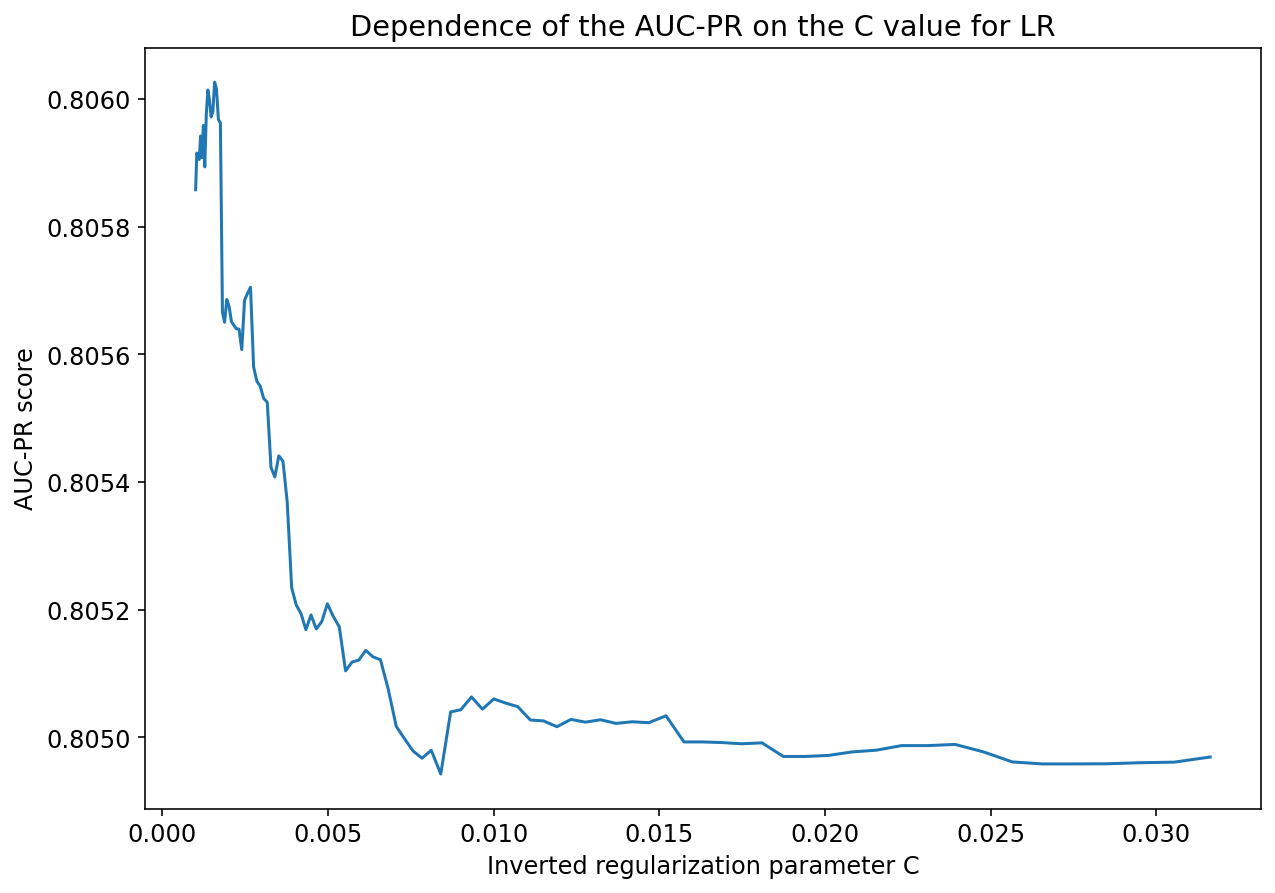

In [10]:
lr_Cs = np.logspace(-3, -1.5, 100, base=10)
lr_cs_dict = dict()

for C in lr_Cs:
    clf = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=C, max_iter=10000))
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_val)[:,1]
    precision, recall, _ = precision_recall_curve(y_val, y_proba, pos_label=1)
    lr_cs_dict[C] = auc(recall, precision)


plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 12
plt.plot(list(cs_dict.keys()), list(cs_dict.values()))
plt.xlabel("Inverted regularization parameter C")
plt.ylabel("AUC-PR score")
plt.title('Dependence of the AUC-PR on the C value for LR')
plt.show()

In [11]:
lr_C_best = list(lr_cs_dict.keys())[np.argmax(np.array(list(lr_cs_dict.values())))]

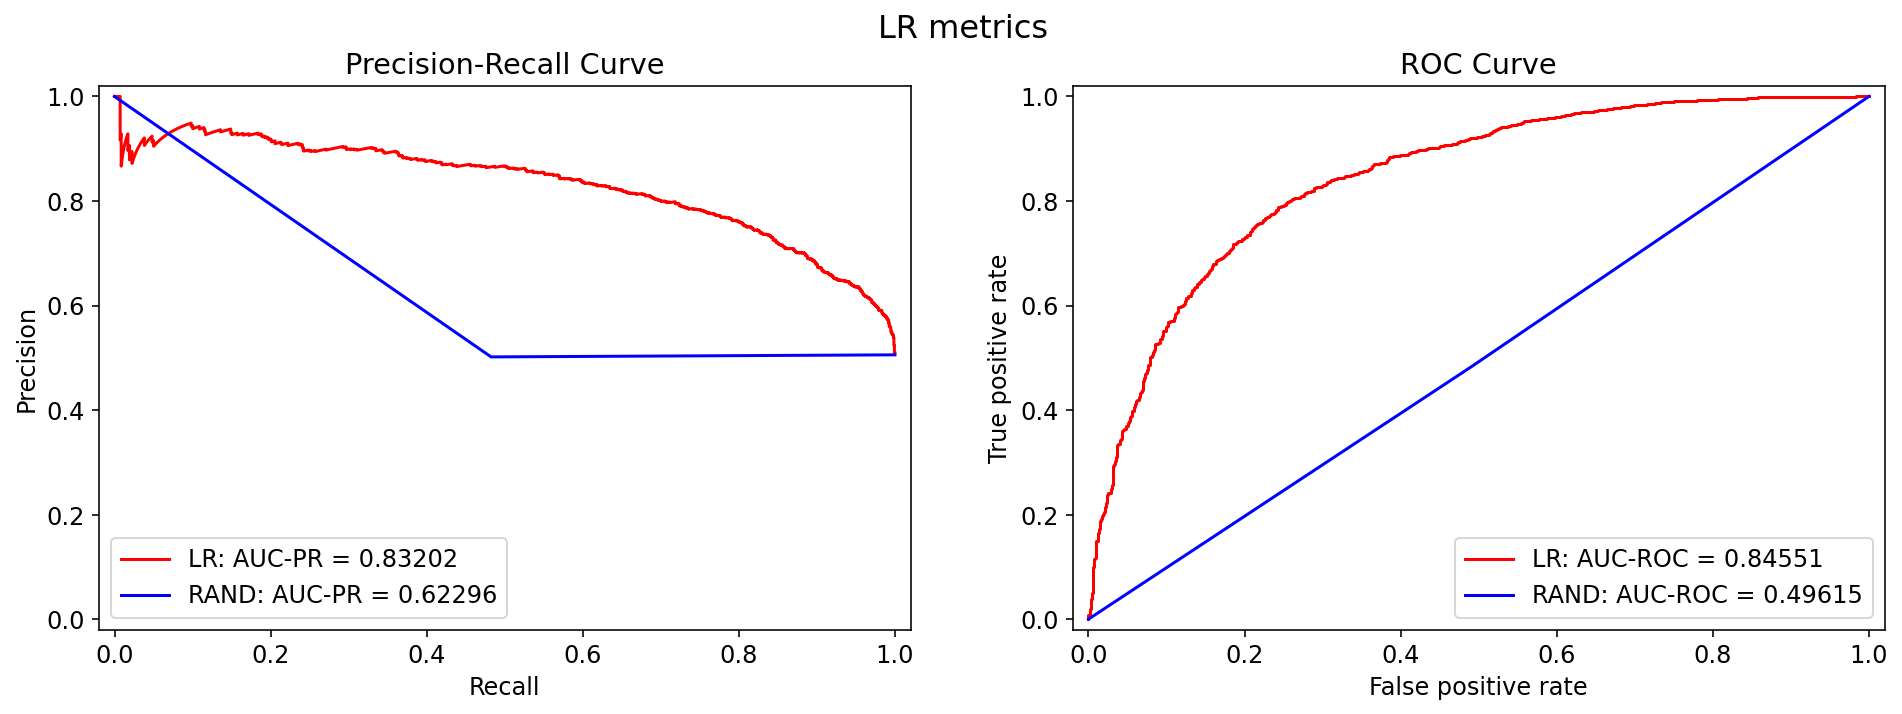

In [12]:
clf = make_pipeline(StandardScaler(), LogisticRegression(C=lr_C_best, max_iter=10000))

# значения метрик для классификатора
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)
fpr, tpr, __ = roc_curve(y_test, y_proba, pos_label=1)
auc_pr = round(auc(recall, precision), 5)
auc_roc = round(auc(fpr, tpr), 5)

# значения метрик для случайного классификатора
y_rand = np.random.choice([0, 1], size=y_test.shape[0], p=[0.5, 0.5])
precision_r, recall_r, _ = precision_recall_curve(y_test, y_rand, pos_label=1)
fpr_r, tpr_r, __ = roc_curve(y_test, y_rand, pos_label=1)
auc_pr_rand = round(auc(recall_r, precision_r), 5)
auc_roc_rand = round(auc(fpr_r, tpr_r), 5)

# графики
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('LR metrics', fontsize=16)

axs[0].plot(recall, precision, 'r', label=f"LR: AUC-PR = {auc_pr}")
axs[0].plot(recall_r, precision_r, 'b', label=f"RAND: AUC-PR = {auc_pr_rand}")
axs[0].set_xlim([-0.02, 1.02])
axs[0].set_ylim([-0.02, 1.02])
axs[0].set_xlabel('Recall')
axs[0].set_ylabel("Precision")
axs[0].title.set_text('Precision-Recall Curve')
axs[0].legend()

axs[1].plot(fpr, tpr, 'r', label=f"LR: AUC-ROC = {auc_roc}")
axs[1].plot(fpr_r, tpr_r, 'b', label=f"RAND: AUC-ROC = {auc_roc_rand}")
axs[1].set_xlim([-0.02, 1.02])
axs[1].set_ylim([-0.02, 1.02])
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel("True positive rate")
axs[1].title.set_text('ROC Curve')
axs[1].legend()

plt.show()

**Ответ:** С точки зрения вычисленных критериев качества (AUC-PR и AUC-ROC) можно сказать, что сильных различий в значениях метрик не наблюдается: в обоих случаях `AUC-PR ~ 0.83` и `AUC-ROC ~ 0.84`. При этом стоит отметить, что значение `AUC-PR` несколько лучше у логистической регрессии, а значение `AUC-ROC` несколько лучше у метода опорных векторов.

Различие в значениях `AUC-ROC` можно объяснить тем, что в методе опорных векторов важнее хорошее разделение, чем правильная оценка вероятностей. Это говорит о том, что полученный классификатор будет чуть меньше ошибаться, но считать не вероятности, а другие значения, показывающие уверенность модели в ответе. То есть классификатор будет разделять лучше, а сортировать объекты по ответам на них будет примерно так же.

Различия в значениях `AUC-PR` можно объяснить тем, что, судя по графикам, после логистической регрессии в отсортированных по выходам модели (в убывающем порядке) ответах в начале списка оказалось меньше объектов отрицательного класса, идущих почти подряд. Именно поэтому график не прогибается вниз, как график `PR-curve` после классификации с помощью `SVM`. В принципе значения в данной метрике настолько незначительны, что их даже можно не рассматривать.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [13]:
X_2, y_2 = make_classification(
    n_samples=2000, n_features=2, n_informative=2, n_redundant=0,
    random_state=103)

In [14]:
from sklearn.svm import SVC
import seaborn as sns

In [15]:
svc = SVC(kernel='linear', C=C_best, max_iter=10000)

svc.fit(X_2, y_2)
w = svc.coef_[0]
b = svc.intercept_[0]
X_support = svc.support_vectors_

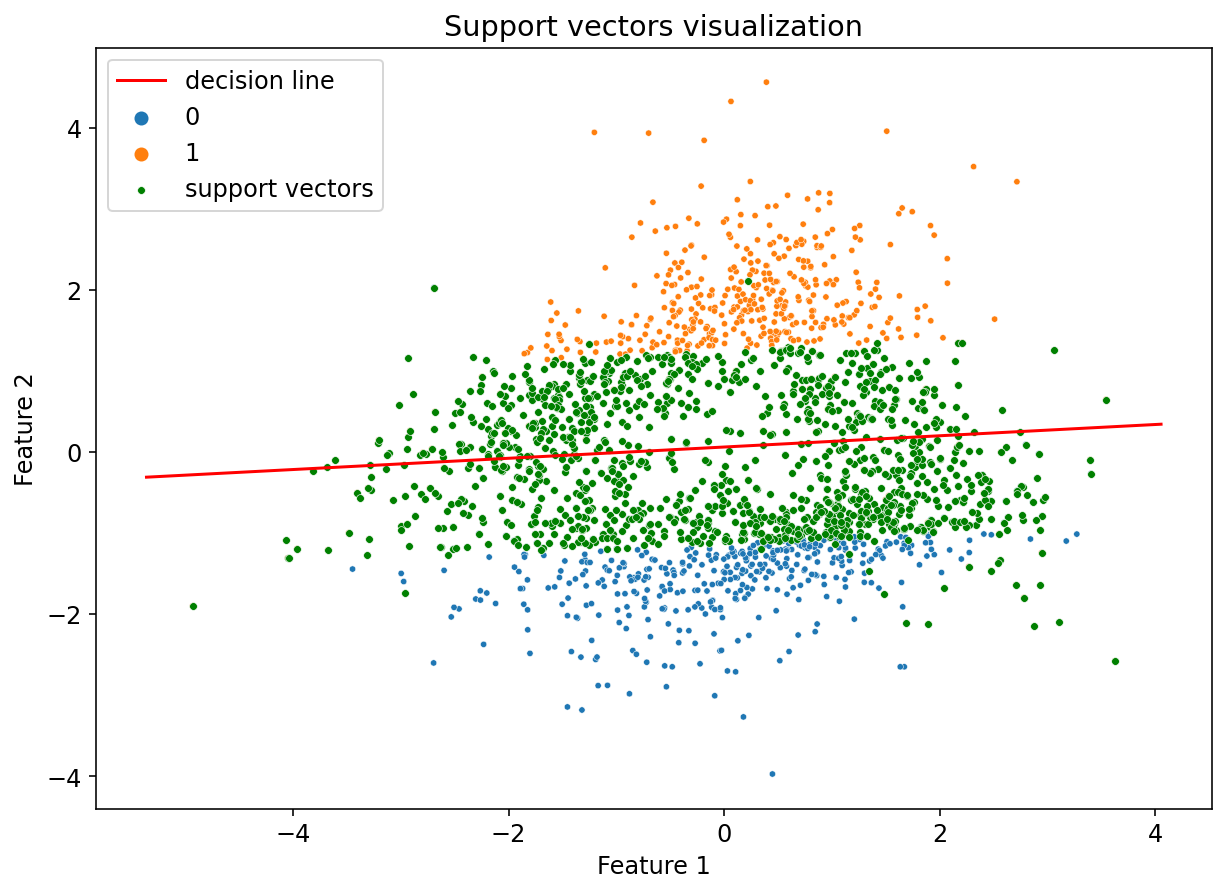

In [16]:
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 12

# объекты с изначальными классами
sns.scatterplot(x=X_2[:, 0], 
                y=X_2[:, 1], 
                hue=y_2, 
                s=10)

# визуализация разделяющей прямой
ax = plt.gca()
xlim = ax.get_xlim()
x_points = np.linspace(xlim[0], xlim[1])
y_points = -(w[0] / w[1]) * x_points - b / w[1]

plt.plot(x_points, y_points, c='r', label='decision line')

# визуализация опорных векторов
sns.scatterplot(x=X_support[:, 0], 
                y=X_support[:, 1], 
                color='green', 
                s=15, label='support vectors')

plt.title('Support vectors visualization')
plt.xlabel('Feature 1')
plt.ylabel("Feature 2")
plt.legend()
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [17]:
lr_clf = LogisticRegression(C=lr_C_best, max_iter=10000)
lr_clf.fit(X_2[:1000], y_2[:1000])
y_pred_2 = lr_clf.predict(X_2[1000:])

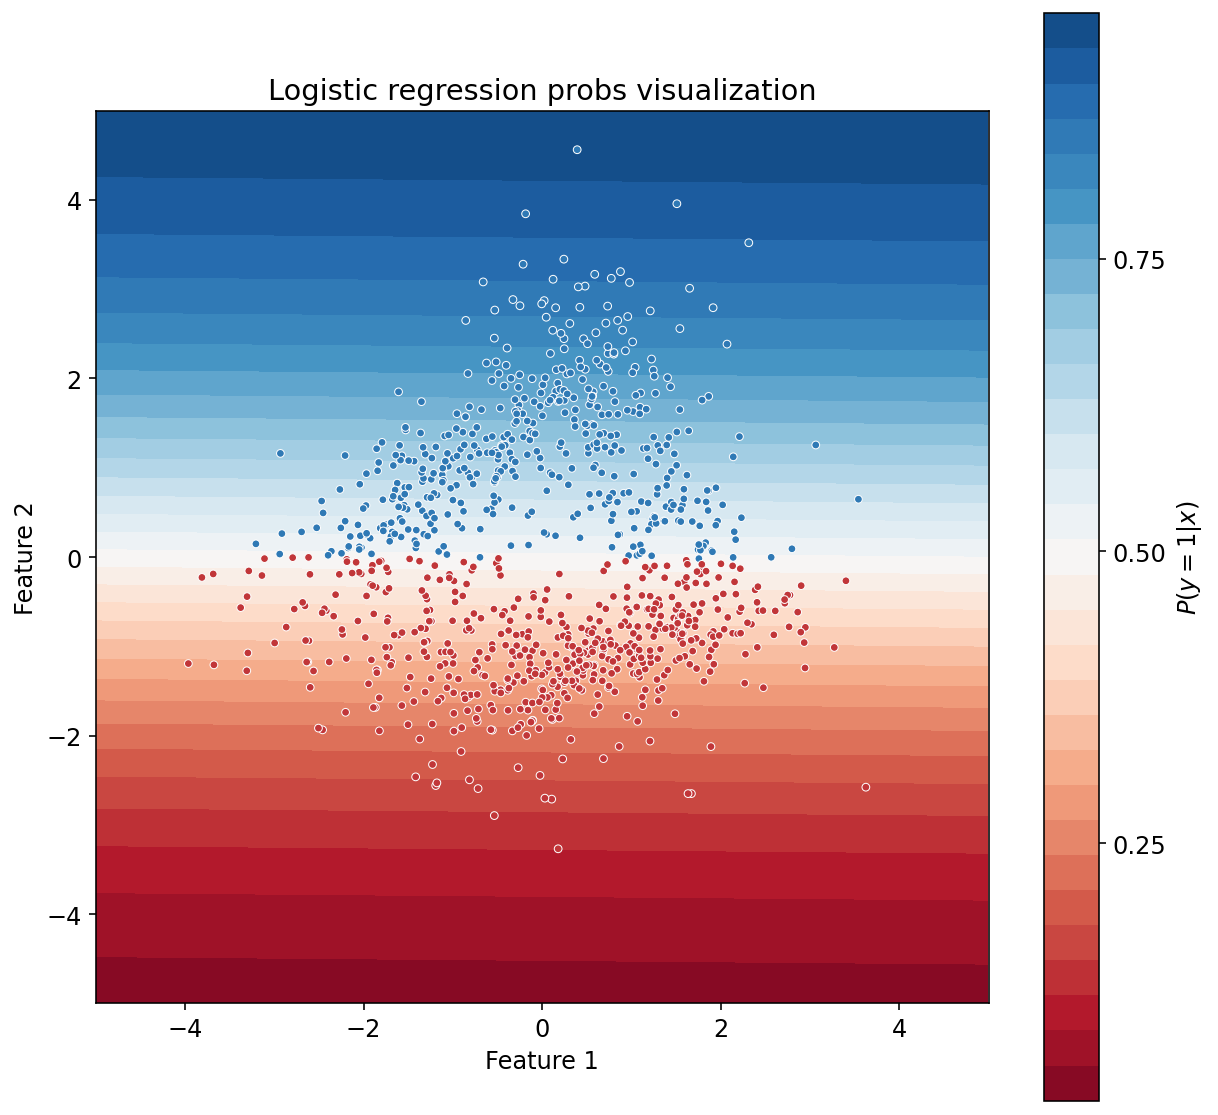

In [18]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]

grid = np.c_[xx.ravel(), yy.ravel()]
probs = lr_clf.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(10, 10))
contour = ax.contourf(xx, yy, probs, 30, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1 | x)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

# цвет точек на графике - это предсказание, а не целевая переменная
# поэтому видно, как все объекты азделены на два класса ровной линией
ax.scatter(X_2[1000:,0], X_2[1000:, 1], c=y_pred_2, s=15,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=0.5)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

plt.title('Logistic regression probs visualization')
plt.xlabel('Feature 1')
plt.ylabel("Feature 2")
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

**Ошибки:**
1. Чтобы получить середину отрезка, его края нужно складывать, а не вычитать
2. Указан отрезок со включенными краями, а значит, правый край тоже надо рассмтаривать, к тому же иначе не будет рассмотрен случай, когда `preds == 1`
3. В список `bin_real_ratios` следует добавлять не минимум из массива, где все элементы и так равны 1, а их количество (или сумму, раз там только единицы), деленную на общее количество объектов, попавших в данный отрезок

In [19]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds <= r)] == 1) / 
                               len(y_test[(preds >= l) & (preds <= r)]))
        
    plt.figure(figsize=(6, 6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.xlabel('Middle points')
    plt.ylabel("Real ratios")
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [20]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [21]:
clf = make_pipeline(StandardScaler(), LogisticRegression(C=lr_C_best, max_iter=10000))
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:, 1]

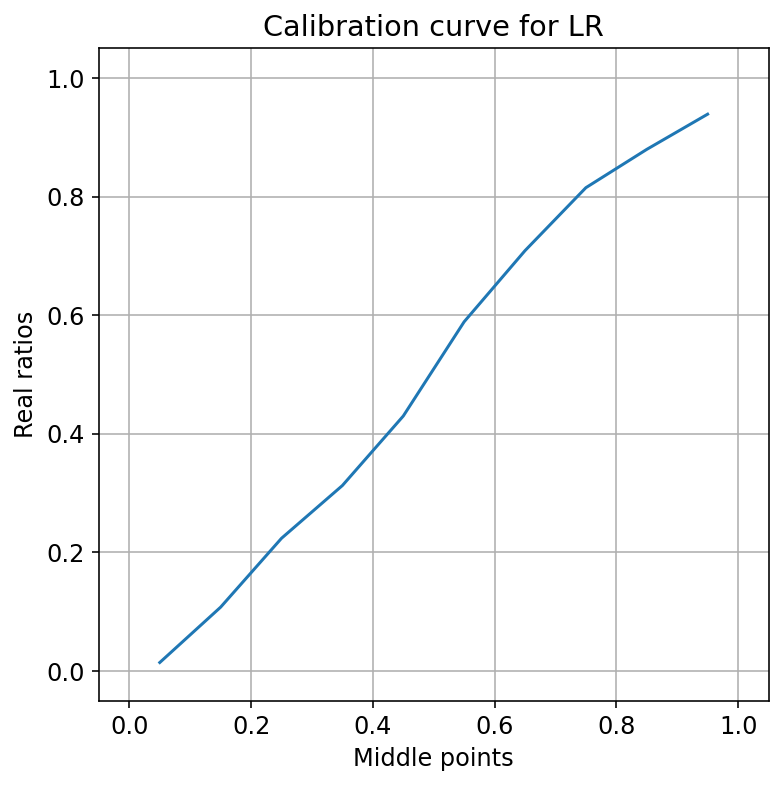

In [22]:
plot_calibration_curve(y_test, preds)
plt.title('Calibration curve for LR')
plt.show()

Логистичекая регрессия действительно правильно предсказывает вероятности - линия почти прямая

In [23]:
svm = make_pipeline(StandardScaler(), LinearSVC(C=C_best, max_iter=10000))
svm.fit(X_train, y_train)
preds = svm.decision_function(X_test)
# zi = (xi – min(x)) / (max(x) – min(x))
preds_normalized = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

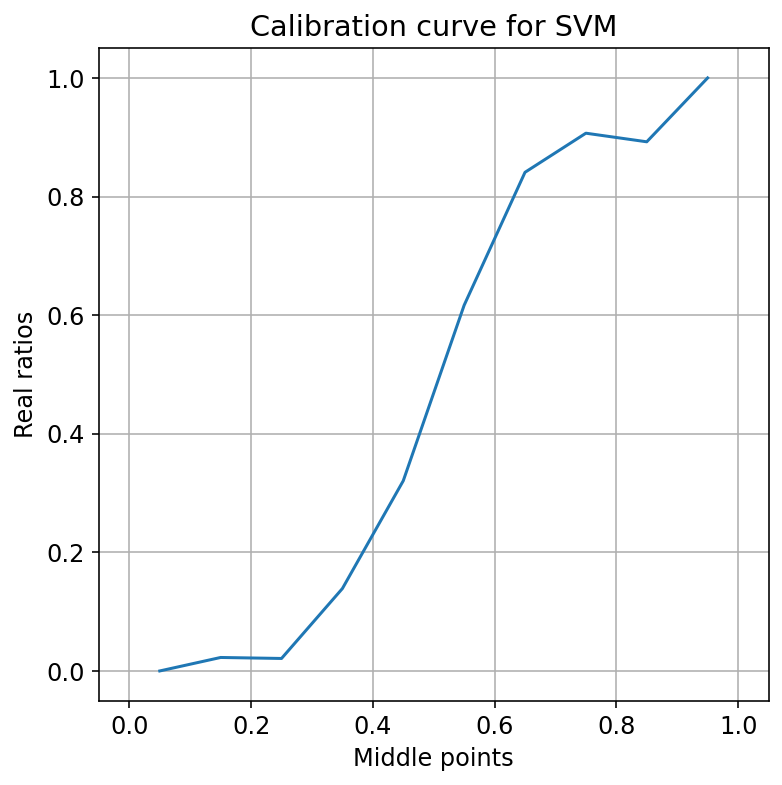

In [24]:
plot_calibration_curve(y_test, preds_normalized)
plt.title('Calibration curve for SVM')
plt.show()

Метод опорных векторов предсказывает вероятности гораздо хуже, поэтому калибровочная кривая совсем не похожа на прямую диагональную линию

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [25]:
from sklearn.calibration import CalibratedClassifierCV

In [26]:
svm = make_pipeline(StandardScaler(), LinearSVC(C=C_best, max_iter=10000))
calibrated_clf = CalibratedClassifierCV(base_estimator=svm)

In [27]:
calibrated_clf.fit(X_train, y_train)
preds = calibrated_clf.predict_proba(X_test)[:, 1]

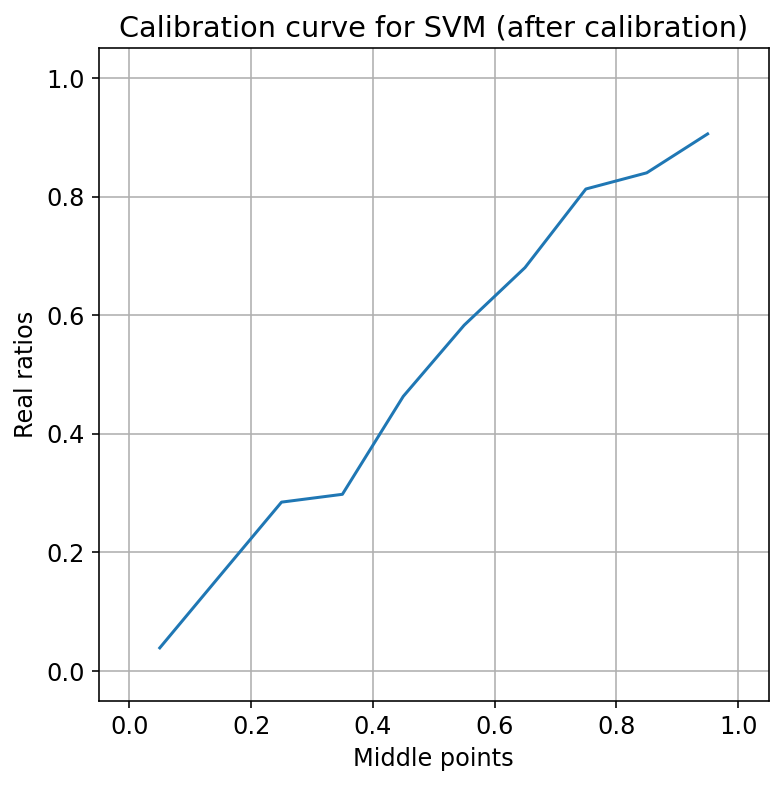

In [28]:
plot_calibration_curve(y_test, preds)
plt.title('Calibration curve for SVM (after calibration)')
plt.show()

Линия на графике выше выглядит уже значительно лучше, чем до калибрации, но прямой ее все еще назвать нельзя. Это говорит о том, что даже после калибрации метод опорных векторов не всегда дает точную оценку вероятности.

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [29]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [30]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip --no-check-certificate
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [31]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 

**Ответ:** Необходимо выбросить признак `duration`, это даже рекомендуется сделать на странице, где размещена информация о признаках в датасете. Все дело в том, что задача состоит в определении того, даст клиент положительный или отрицательный ответ еще до совершения звонка, основываясь на данных о клиенте и его предыдущих контактах с компанией. Продолжительность звонка не известна до начала звонка, более того, если продолжительность звонка равна нулю (звонок не состоялся), то ответом автоматически является "нет".

In [32]:
df = df.drop(columns=['duration'])

In [33]:
X = df.drop(columns=['y'])
y = df['y']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=777, stratify=y)

In [35]:
num_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                'cons.price.idx', 'euribor3m', 'nr.employed']
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                'contact', 'month', 'day_of_week', 'poutcome']

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Метрика `AUC-ROC` может быть слишком оптимистичной в ситуации с сильно несбалансированными классами, то есть с небольшим количеством образцов одного из классов.

In [36]:
from sklearn.preprocessing import OrdinalEncoder
import time

In [37]:
start = time.time()

enc = OrdinalEncoder()
enc.fit(X_train[cat_features])
X_train[cat_features] = enc.transform(X_train[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])

enc_y = OrdinalEncoder()
y_train = enc_y.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = enc_y.transform(np.array(y_test).reshape(-1, 1))

clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
clf.fit(X_train, y_train.ravel())
y_proba_ord = clf.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_ord)

auc_pr_ord = auc(recall, precision)

end = time.time()

X_train[cat_features] = enc.inverse_transform(X_train[cat_features])
X_test[cat_features] = enc.inverse_transform(X_test[cat_features])

print(f'Execution time: {end - start} sec')

Execution time: 0.4025709629058838 sec


In [38]:
auc_pr_ord

0.44186656215605213

In [39]:
dist = pd.DataFrame(df.groupby('y').size()).reset_index()

Как и предполагалось, есть сильный дисбаланс классов, а значит, метрика `AUC-ROC` действительно не будет полезной:

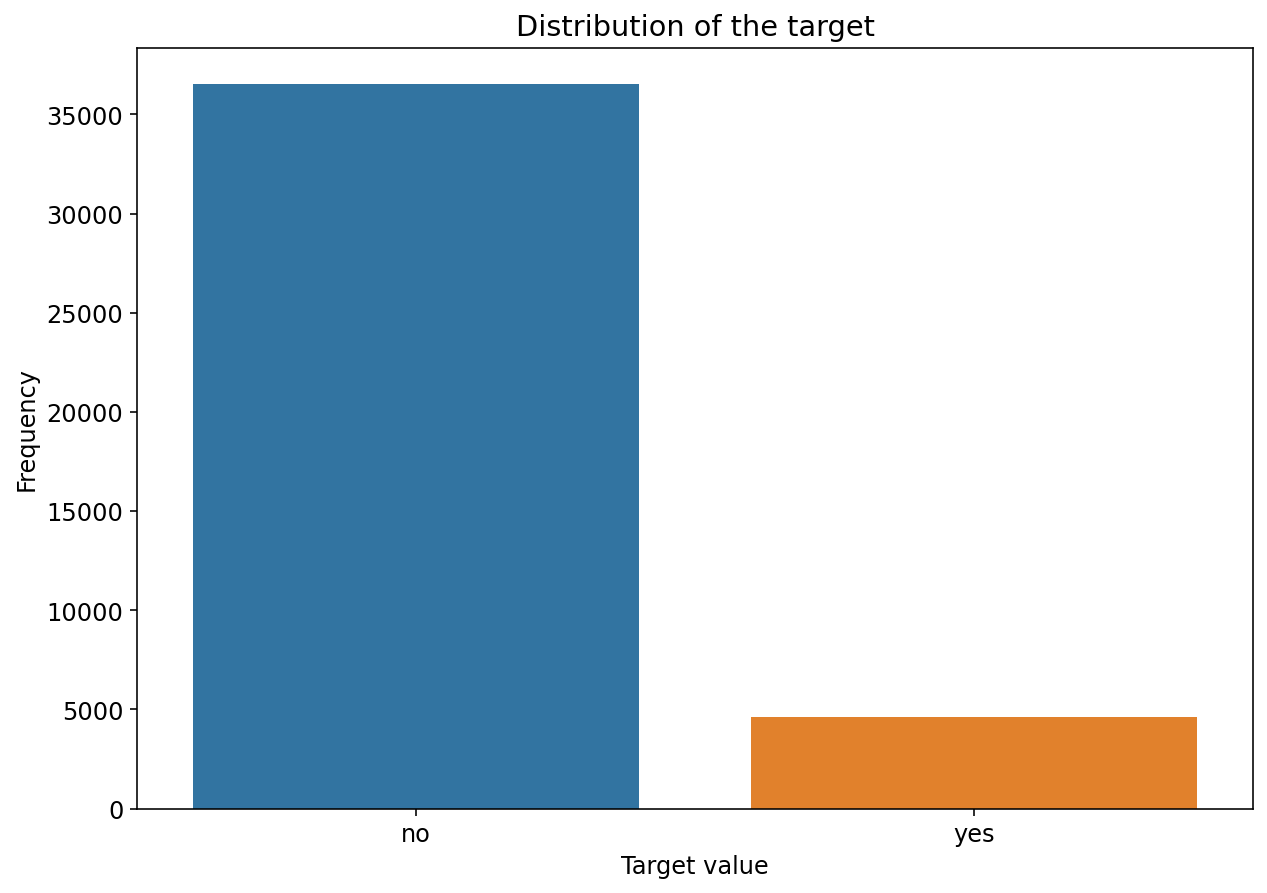

In [40]:
sns.barplot(x='y', y=0, data=dist)
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.title('Distribution of the target')
plt.show()

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [42]:
start = time.time()

tr = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), cat_features),
    ('scaling', StandardScaler(), num_features)
])

tr.fit(X_train)

clf_ohe = LogisticRegression(C=1.0, max_iter=10000)
clf_ohe.fit(tr.transform(X_train).toarray(), y_train.ravel())
y_proba_ohe = clf_ohe.predict_proba(tr.transform(X_test).toarray())[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_ohe)

auc_pr_ohe = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 2.114924907684326 sec


In [43]:
y_proba_ohe = clf_ohe.predict_proba(tr.transform(X_train).toarray())[:, 1]

precision, recall, _ = precision_recall_curve(y_train, y_proba_ohe)

auc_pr_train = auc(recall, precision)

auc_pr_train

0.4573880930417494

In [44]:
auc_pr_ohe

0.44881328949746924

In [45]:
len(set(X_train['age'].values))

76

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

**Ответ:** время обучения выросло за счет увеличения времени, уходящего на трансформацию данных. Качество, судя по метрике `AUC-PR` несколько снизилось, если сравнивать с `OHE`, или выросло, если сравнивать с `OrdinalEncoder`. *Интересное:* на тестовой выборке показатели лучше, чем на тренировочной.

__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

In [47]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
        self.vals = dict()
        
    def fit(self, X, y):
        """
        X: pd.DataFrame
        y: pd.Series
        """ 
        
        data = pd.concat([X[self.cat_features].reset_index(), y.reset_index()], axis=1)
        data = data.rename(columns={0: 'y'})
        data = data.drop(columns=['index'])
        
        for feature in self.cat_features:
            self.vals[feature] = dict()
            for value in set(data[feature].values):
                self.vals[feature][value] = data[data[feature] == value]['y'].mean()
        
        return self

    def transform(self, X):
        data = X.copy()
        for feature in self.cat_features:
            for value in set(list(self.vals[feature].keys())):
                data.loc[data[feature] == value, feature] = self.vals[feature][value]
        return data

In [48]:
start = time.time()

enc = TargetEncoder(cat_features)
enc.fit(X_train, pd.DataFrame(y_train.reshape(1, -1)[0]))

clf_targ = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
clf_targ.fit(enc.transform(X_train).to_numpy(), y_train.ravel())
y_proba_targ = clf_targ.predict_proba(enc.transform(X_test).to_numpy())[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_targ)

auc_pr_targ = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 5.6203389167785645 sec


In [49]:
y_proba_train = clf_targ.predict_proba(enc.transform(X_train).to_numpy())[:, 1]

precision, recall, _ = precision_recall_curve(y_train, y_proba_train)

auc_pr_train = auc(recall, precision)

In [50]:
auc_pr_train

0.4436453150685299

In [51]:
auc_pr_targ

0.4423670313817223

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [52]:
def add_noise(X, mu, sigma):
    return X + np.random.normal(mu, sigma, X.shape)

In [53]:
start = time.time()

enc = TargetEncoder(cat_features)
enc.fit(X_train, pd.DataFrame(y_train.reshape(1, -1)[0]))

mu = 0
sigma = 0.002
train, test = enc.transform(X_train), enc.transform(X_test)
train[cat_features] = add_noise(train[cat_features].to_numpy(), mu, sigma)
test[cat_features] = add_noise(test[cat_features].to_numpy(), mu, sigma)

clf_noise = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
clf_noise.fit(train, y_train.ravel())
y_proba_noise = clf_noise.predict_proba(test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_noise)

auc_pr_noise = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 5.112405061721802 sec


In [54]:
auc_pr_noise

0.4426641712473155

Результаты стали немного лучше, чем в обучении без шумов, но значение показателя увеличилось лишь на несколько десятитысячных. Скорее всего все дело в том, что переобучения и так не было, поэтому шумы особой погоды не сделали.

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [55]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? 

*Ответ:* Если окажется, что на этой редкой категории везде ответ 0 или очень мало ответов 1, то такая категория может быть заменена на очень малое число или даже на ноль, в связи с чем она будет занулять свой коэффициент и не будет оказывать влияния на ответ.

По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

Сглаживание добавим прямо в классе `TargetEncoder` - для этого просто добавим поле `C` с дефолтным значением 0. Так ответы в предыдущих заданиях не изменятся и класс можно будет все так же применять для расчетов выше, при этом появится сглаживание (в методе `fit`)

In [56]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features, C=0):
        self.cat_features = cat_features
        self.vals = dict()
        self.C = C
        
    def fit(self, X, y):
        """
        X: pd.DataFrame
        y: pd.Series
        """ 
        
        data = pd.concat([X[self.cat_features].reset_index(), y.reset_index()], axis=1)
        data = data.rename(columns={0: 'y'})
        data = data.drop(columns=['index'])
        
        self.global_mean = y.to_numpy().mean()
        
        for feature in self.cat_features:
            self.vals[feature] = dict()
            for value in set(data[feature].values):
                num_vals = data[data[feature] == value]['y'].size
                mean = data[data[feature] == value]['y'].mean()
                self.vals[feature][value] = (mean * num_vals + self.C) / (num_vals + self.C)
        return self

    def transform(self, X):
        data = X.copy()
        for feature in self.cat_features:
            for value in set(list(self.vals[feature].keys())):
                data.loc[data[feature] == value, feature] = self.vals[feature][value]
        return data

In [57]:
start = time.time()

enc = TargetEncoder(cat_features, C=0.02)
enc.fit(X_train, pd.DataFrame(y_train.reshape(1, -1)[0]))

mu = 0
sigma = 0.0015
train, test = enc.transform(X_train), enc.transform(X_test)
train[cat_features] = add_noise(train[cat_features].to_numpy(), mu, sigma)
test[cat_features] = add_noise(test[cat_features].to_numpy(), mu, sigma)

clf_smooth = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
clf_smooth.fit(train, y_train.ravel())
y_proba_smooth = clf_smooth.predict_proba(test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_smooth)

auc_pr_smooth = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 5.53157114982605 sec


In [58]:
auc_pr_smooth

0.4423128918497381

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (78), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [59]:
# сколько значений
len(set(df['age'].values))

78

In [60]:
cat_features_age = ['age'] + cat_features

In [61]:
start = time.time()

enc = TargetEncoder(cat_features_age, C=0.02)
enc.fit(X_train, pd.DataFrame(y_train.reshape(1, -1)[0]))

mu = 0
sigma = 0.0025
train, test = enc.transform(X_train), enc.transform(X_test)
train[cat_features_age] = add_noise(train[cat_features_age].to_numpy(), mu, sigma)
test[cat_features_age] = add_noise(test[cat_features_age].to_numpy(), mu, sigma)

clf_age = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
clf_age.fit(train, y_train.ravel())
y_proba_age = clf_age.predict_proba(test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_age)

auc_pr_age = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 5.580254077911377 sec


In [62]:
auc_pr_age

0.44023694501749183

Сильно лучше не стало, значение все еще колеблется в тех же пределах.

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 11, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [63]:
cat_features_no_time = ['job', 'marital', 'education', 'default',
                      'housing', 'loan', 'contact', 'poutcome']

In [64]:
replace_features = ['month', 'day_of_week']
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
weekdays = ['mon', 'tue', 'wed', 'thu', 'fri']

In [65]:
def make_numeric(replace_features, X):
    for feature in replace_features:
        for value in set(X[feature].values):
            if feature == 'month':
                X.loc[X[feature] == value, feature] = months.index(value)
            elif feature == 'day_of_week':
                X.loc[X[feature] == value, feature] = weekdays.index(value)
    return X

In [66]:
start = time.time()

enc = TargetEncoder(cat_features_no_time, C=0.02)
enc.fit(X_train, pd.DataFrame(y_train.reshape(1, -1)[0]))

mu = 0
sigma = 0.002
train = make_numeric(replace_features, enc.transform(X_train))
test = make_numeric(replace_features, enc.transform(X_test))

train[cat_features_no_time] = add_noise(train[cat_features_no_time].to_numpy(), mu, sigma)
test[cat_features_no_time] = add_noise(test[cat_features_no_time].to_numpy(), mu, sigma)

clf_no_time = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
clf_no_time.fit(train, y_train.ravel())
y_proba_no_time = clf_no_time.predict_proba(test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_no_time)

auc_pr_no_time = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 3.9201767444610596 sec


In [67]:
auc_pr_no_time

0.4356317725505811

Вычисляться стало быстрее после изменения типа признаков "месяц" и "день недели", но качество не увеличилось.

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Плюсы счетчиков:
* Во-первых, счетчики не плодят огромное количество признаков и количество признаков не меняется - это позволяет гораздо более удобно читать данные, а также не засоряет данными практически пустиыми столбцами (для редких категорий, напимер).
* Во-вторых, не размножая признаки, счетчики дают приблизительно такой же результат, как и one-hot-кодирование, а если применить шум, то даже результат получше.

Минусы счетчиков:
* По сравнению с one-hot-кодированием счетчики гораздо тяжелее в понимании и реализации
* Чтобы счетчики хорошо работали, надо применить всяческие ухищрения, вроде шума, разных методов подсчета, сглаживания и тд - это, несомненно, усложняет работу.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [120]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

В результате получилось 60 признаков, из которых 52 - бинарные категориальные признаки.

In [121]:
enc = OneHotEncoder(drop='if_binary', sparse=False)
enc.fit(X_train[cat_features])
new_cats = enc.get_feature_names_out()
X_train = pd.concat([pd.DataFrame(enc.transform(X_train[cat_features]), columns=new_cats),
                     X_train.reset_index()[num_features]],
                    axis=1)
X_test = pd.concat([pd.DataFrame(enc.transform(X_test[cat_features]), columns=new_cats),
                    X_test.reset_index()[num_features]],
                   axis=1)

In [122]:
X_train.shape[1]

60

In [123]:
X_train.shape[1] - len(num_features)

52

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [124]:
# нет масштабирования
# не отобранные признаки
start = time.time()

clf_ohe = LogisticRegression(C=1.0, max_iter=10000)
clf_ohe.fit(X_train, y_train.ravel())
y_proba_ohe = clf_ohe.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_ohe)

auc_pr_ohe = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 1.2954769134521484 sec


In [125]:
print(f'AUC-PR score for not scaled, one-hot-encoded features: {auc_pr_ohe}')

AUC-PR score for not scaled, one-hot-encoded features: 0.43734685630818504


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

*Ответ:* качество совсем немного выросло

In [126]:
# отбор признаков
start = time.time()

ws = clf_ohe.coef_
coefs = pd.DataFrame(list(zip(X_train.columns, ws[0])), columns=['Features', 'Coefficient']).set_index('Features')
new_cols = abs(coefs['Coefficient']).nlargest(40).reset_index()['Features'].values

end = time.time()
print(f'Execution time: {end - start} sec')

Execution time: 0.024401187896728516 sec


In [127]:
# нет масштабирования
# отобранные признаки
start = time.time()

clf_40best = LogisticRegression(C=1.0, max_iter=10000)
clf_40best.fit(X_train[new_cols], y_train.ravel())
y_proba_40best = clf_40best.predict_proba(X_test[new_cols])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_40best)

auc_pr_40best = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 2.469405174255371 sec


In [128]:
print(f"AUC-PR score for not scaled features, embedded method: {auc_pr_40best}")

AUC-PR score for not scaled features, embedded method: 0.4445852733882553


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [174]:
# функция для масштабирования определенного набора признаков
# нужна, чтобы не менять X_train и X_test
def scale_features(fitted_scaler, X):
    features_list = fitted_scaler.get_feature_names_out()
    return pd.concat([X.drop(features_list, axis=1).reset_index().drop(['index'], axis=1),
                      pd.DataFrame(fitted_scaler.transform(X[features_list]), columns=features_list)],
                     axis=1)

In [130]:
# масштабируем все числовые признаки
# обучаем на всех признаках с отмасштабированными числовыми

scaler = StandardScaler()
scaler.fit(X_train[num_features])

start = time.time()

clf_num_scaled = LogisticRegression(C=1.0, max_iter=10000)
clf_num_scaled.fit(scale_features(scaler, X_train), y_train.ravel())
y_proba_num_scaled = clf_num_scaled.predict_proba(scale_features(scaler, X_test))[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_num_scaled)

auc_pr_num_scaled = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 2.1298131942749023 sec


In [131]:
print(f"AUC-PR score, numeric features scaled: {auc_pr_num_scaled}")

AUC-PR score, numeric features scaled: 0.4462087599271459


Омасштабировали числовые признаки - теперь отберем 40 лучших и посмотрим на изменение качества

In [132]:
# отбор признаков с учетом отмасштабированных числовых
start = time.time()

ws = clf_num_scaled.coef_
coefs_num_scaled = pd.DataFrame(list(zip(X_train.columns, ws[0])), 
                                columns=['Features', 'Coefficient']).set_index('Features')
new_cols_num_scaled = abs(coefs_num_scaled['Coefficient']).nlargest(40).reset_index()['Features'].values

end = time.time()
print(f'Execution time: {end - start} sec')

Execution time: 0.007840871810913086 sec


После масштабирования только числовых признаков список отобранных лучших 40 признаков поменялся:

In [133]:
(new_cols == new_cols_num_scaled).all()

False

In [134]:
# данные отмасштабированы
# обучаем только на отобранных признаках с отмасштабированными числовыми
start = time.time()

clf_40best_num_scaled = LogisticRegression(C=1.0, max_iter=10000)
clf_40best_num_scaled.fit(scale_features(scaler, X_train)[new_cols_num_scaled], 
                          y_train.ravel())
y_proba_40best_num_scaled = clf_40best_num_scaled.predict_proba(scale_features(scaler, 
                                                                               X_test)[new_cols_num_scaled]
                                                               )[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_40best_num_scaled)

auc_pr_40best_num_scaled = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 1.0593037605285645 sec


In [135]:
print(f"AUC-PR score, numeric scaled, embedded method: {auc_pr_40best_num_scaled}")

AUC-PR score, numeric scaled, embedded method: 0.4477235696379557


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

*Ответ:*
* Список признаков изменился
* Качество чуть-чуть улучшилось, если смотреть на масштабирование всех признаков без отбора, и ухудшилось, если смотреть на отбор после масштбаирования только числовых признаков

In [136]:
# масштабируем все признаки
# обучаем на всех признаках
start = time.time()

scaler = StandardScaler()
scaler.fit(X_train)

clf_all_scaled = LogisticRegression(C=1.0, max_iter=10000)
clf_all_scaled.fit(scale_features(scaler, X_train), y_train.ravel())
y_proba_all_scaled = clf_all_scaled.predict_proba(scale_features(scaler, X_test))[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_all_scaled)

auc_pr_all_scaled = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 0.4961681365966797 sec


In [137]:
print(f"AUC-PR score, all features scaled: {auc_pr_all_scaled}")

AUC-PR score, all features scaled: 0.44618808554064926


In [138]:
# отбор признаков с учетом масштабирования всех признаков
start = time.time()

ws = clf_all_scaled.coef_
coefs_all_scaled = pd.DataFrame(list(zip(X_train.columns, ws[0])), 
                                columns=['Features', 'Coefficient']).set_index('Features')
new_cols_all_scaled = abs(coefs_all_scaled['Coefficient']).nlargest(40).reset_index()['Features'].values

end = time.time()
print(f'Execution time: {end - start} sec')

Execution time: 0.009579181671142578 sec


Список отборанных признаков после масштабирования всех признаков не совпадает как со списком после масштабирования только числовых, так и со списком признаков, отобранных без масштабирования:

In [139]:
(new_cols_num_scaled == new_cols_all_scaled).all()

False

In [140]:
(new_cols == new_cols_all_scaled).all()

False

In [141]:
# данные отмасштабированы
# обучаем только на отобранных признаках с всеми отмасштабированными признаками
start = time.time()

clf_40best_all_scaled = LogisticRegression(C=1.0, max_iter=10000)
clf_40best_all_scaled.fit(scale_features(scaler, X_train)[new_cols_all_scaled], 
                          y_train.ravel())
y_proba_40best_all_scaled = clf_40best_all_scaled.predict_proba(scale_features(scaler, 
                                                                               X_test)[new_cols_all_scaled]
                                                               )[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_40best_all_scaled)

auc_pr_40best_all_scaled = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 0.573239803314209 sec


In [142]:
print(f"AUC-PR score, all features scaled, embedded method: {auc_pr_40best_all_scaled}")

AUC-PR score, all features scaled, embedded method: 0.4464967071893406


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [143]:
train = pd.concat([X_train.reset_index(), y_train.reset_index()], axis=1).drop(columns=['index'])

In [144]:
start = time.time()

sigma_plus = train[train['y'] == 1].drop('y', axis=1).std().values
sigma_minus = train[train['y'] == 0].drop('y', axis=1).std().values
mu_plus = train[train['y'] == 1].drop('y', axis=1).mean().values
mu_minus = train[train['y'] == 0].drop('y', axis=1).mean().values

n_plus = np.count_nonzero(y_train == 0)
n_minus = y_train.shape[0] - n_plus

f = abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus + n_minus * sigma_minus) / (n_plus + n_minus))

ind = np.sort(np.argpartition(f, -40)[-40:])
selected_cols = X_train.columns[ind]

end = time.time()
print(f'Execution time: {end - start} sec')

Execution time: 0.10010695457458496 sec


In [145]:
# численные признаки отмасштабированы
# обучаем только на отобранных признаках 
start = time.time()

scaler = StandardScaler()
scaler.fit(X_train[num_features])

clf_40f = LogisticRegression(C=1.0, max_iter=10000)
clf_40f.fit(scale_features(scaler, X_train)[selected_cols], 
                          y_train.ravel())
y_proba_40f = clf_40f.predict_proba(scale_features(scaler, X_test)[selected_cols]
                                                               )[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_40f)

auc_pr_40f = auc(recall, precision)

end = time.time()

print(f'Execution time: {end - start} sec')

Execution time: 0.9726462364196777 sec


In [146]:
auc_pr_40f

0.4472845919590693

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [147]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=3/7, 
                                                  random_state=777, stratify=y_train)

In [212]:
from tqdm.notebook import tqdm

In [231]:
start = time.time()
auc_pr_best = [0]
features_to_check = X_train.columns
deleted = []
for i in tqdm(range(features_to_check.shape[0] - 40)):
    auc_prs = []
    for exclude in tqdm(features_to_check):
        numeric = np.setdiff1d(num_features, [exclude] + deleted)
        
        scaler = StandardScaler()
        scaler.fit(X_train[numeric])
        
        clf_greedy = LogisticRegression(C=1.0, max_iter=10000)
        clf_greedy.fit(scale_features(scaler, X_train.drop([exclude] + deleted, axis=1)), y_train.ravel())
        y_proba_greedy = clf_greedy.predict_proba(scale_features(scaler, 
                                                                 X_val.drop([exclude] + deleted, axis=1)))[:, 1]

        precision, recall, _ = precision_recall_curve(y_val, y_proba_greedy)

        auc_prs.append(auc(recall, precision))
    
    auc_prs = np.array(auc_prs)
    if np.max(auc_prs - auc_pr_best[-1]) <= 0:
        print('Negative growth - loop broken')
        break
    else:
        auc_pr_best.append(np.max(auc_prs))
        ind = np.argmax(auc_prs)
        print(f'features_to_check: "{features_to_check[ind]}" is gone')
        deleted.append(features_to_check[ind])
        features_to_check = np.delete(features_to_check, ind)

end = time.time()
print(f'Execution_time: {end - start} sec')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

features_to_check: "previous" is gone


  0%|          | 0/59 [00:00<?, ?it/s]

features_to_check: "month_aug" is gone


  0%|          | 0/58 [00:00<?, ?it/s]

features_to_check: "month_apr" is gone


  0%|          | 0/57 [00:00<?, ?it/s]

features_to_check: "job_retired" is gone


  0%|          | 0/56 [00:00<?, ?it/s]

features_to_check: "job_housemaid" is gone


  0%|          | 0/55 [00:00<?, ?it/s]

features_to_check: "job_management" is gone


  0%|          | 0/54 [00:00<?, ?it/s]

features_to_check: "job_self-employed" is gone


  0%|          | 0/53 [00:00<?, ?it/s]

features_to_check: "job_entrepreneur" is gone


  0%|          | 0/52 [00:00<?, ?it/s]

features_to_check: "month_jul" is gone


  0%|          | 0/51 [00:00<?, ?it/s]

features_to_check: "marital_divorced" is gone


  0%|          | 0/50 [00:00<?, ?it/s]

features_to_check: "marital_single" is gone


  0%|          | 0/49 [00:00<?, ?it/s]

features_to_check: "marital_married" is gone


  0%|          | 0/48 [00:00<?, ?it/s]

features_to_check: "age" is gone


  0%|          | 0/47 [00:00<?, ?it/s]

features_to_check: "job_student" is gone


  0%|          | 0/46 [00:00<?, ?it/s]

features_to_check: "marital_unknown" is gone


  0%|          | 0/45 [00:00<?, ?it/s]

features_to_check: "job_unemployed" is gone


  0%|          | 0/44 [00:00<?, ?it/s]

features_to_check: "month_dec" is gone


  0%|          | 0/43 [00:00<?, ?it/s]

features_to_check: "day_of_week_mon" is gone


  0%|          | 0/42 [00:00<?, ?it/s]

features_to_check: "education_basic.6y" is gone


  0%|          | 0/41 [00:00<?, ?it/s]

features_to_check: "housing_unknown" is gone
Execution_time: 825.261953830719 sec


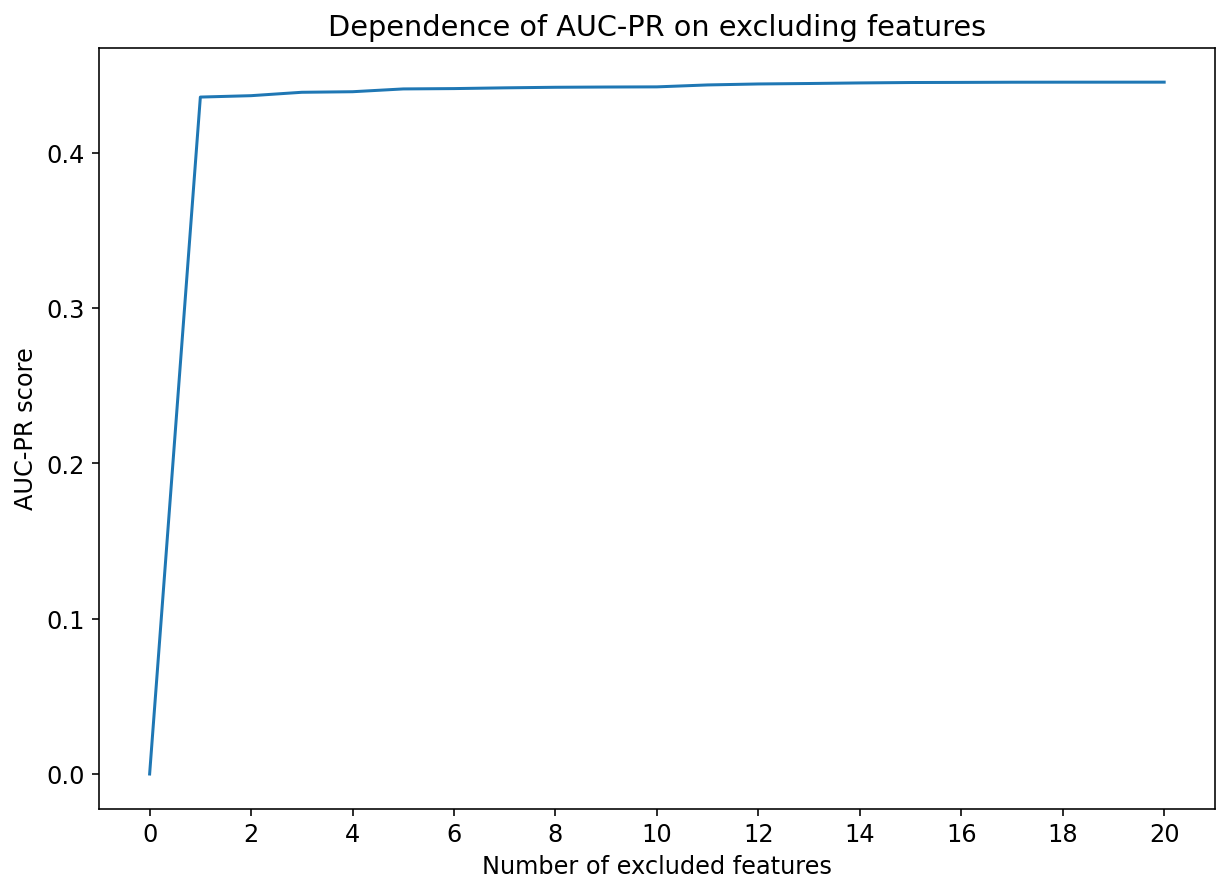

In [233]:
plt.plot(np.arange(0, len(auc_pr_best), 1), auc_pr_best)
plt.xticks(np.arange(0, len(auc_pr_best), 2))
plt.xlabel("Number of excluded features")
plt.ylabel("AUC-PR score")
plt.title('Dependence of AUC-PR on excluding features')
plt.show()

Как можно заметить по графику выше, выкидывание одного признака, дающее наибольший прирост, до тех пор, пока не останется нужное количество признаков, способствует улучшению значения метрики.

In [234]:
scaler = StandardScaler()
scaler.fit(X_train[np.setdiff1d(num_features, deleted)])

clf = LogisticRegression(C=1.0, max_iter=10000)
clf.fit(scale_features(scaler, X_train.drop(deleted, axis=1)), y_train.ravel())
y_proba = clf.predict_proba(scale_features(scaler, X_test.drop(deleted, axis=1)))[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)

auc(recall, precision)

0.44770139655541086

На тестовой выборке результат после выкидывания признаков тоже неплохой

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [249]:
start = time.time()
auc_pr_best = [0]
features_to_check = X_train.columns
included = []
for i in tqdm(range(40)):
    auc_prs = []
    for include in tqdm(features_to_check):
        numeric = np.intersect1d(num_features, included + [include])
        
        clf_greedy = LogisticRegression(C=1.0, max_iter=10000)
        if len(numeric) != 0:
            scaler = StandardScaler()
            scaler.fit(X_train[numeric])
            
            clf_greedy.fit(scale_features(scaler, X_train[[include] + included]), y_train.ravel())
            y_proba_greedy = clf_greedy.predict_proba(scale_features(scaler, 
                                                                     X_val[[include] + included]))[:, 1]
        else:
            clf_greedy.fit(X_train[[include] + included], y_train.ravel())
            y_proba_greedy = clf_greedy.predict_proba(X_val[[include] + included])[:, 1]
        
        precision, recall, _ = precision_recall_curve(y_val, y_proba_greedy)

        auc_prs.append(auc(recall, precision))
    
    auc_prs = np.array(auc_prs)
    # условие проверки величины приращения качества
    if np.max(auc_prs - auc_pr_best[-1]) <= 0:
        print('Negative growth - loop broken')
        break
    else:
        auc_pr_best.append(np.max(auc_prs))
        ind = np.argmax(auc_prs)
        print(f'features_to_check: "{features_to_check[ind]}" is added')
        included.append(features_to_check[ind])
        features_to_check = np.delete(features_to_check, ind)

end = time.time()
print(f'Execution_time: {end - start} sec')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

features_to_check: "default_yes" is added


  0%|          | 0/59 [00:00<?, ?it/s]

Negative growth - loop broken
Execution_time: 9.212517261505127 sec


In [251]:
included

['default_yes']

In [250]:
clf = LogisticRegression(C=1.0, max_iter=10000)
clf.fit(X_train[included], y_train.ravel())
y_proba = clf.predict_proba(X_test[included])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)

auc(recall, precision)

0.5563243505705269

Алгоритм с оставленным условием на проверку приращение говорит, что приращение отрицательное при добавлении к отобранному на первом шаге признаку любого второго, поэтому запустим ячейку выше еще раз, но удалим условие на проверку приращения, чтобы посмотреть на динамику значений метрики:

In [253]:
start = time.time()
auc_pr_best = [0]
features_to_check = X_train.columns
included = []
for i in tqdm(range(40)):
    auc_prs = []
    for include in tqdm(features_to_check):
        numeric = np.intersect1d(num_features, included + [include])
        
        clf_greedy = LogisticRegression(C=1.0, max_iter=10000)
        if len(numeric) != 0:
            scaler = StandardScaler()
            scaler.fit(X_train[numeric])
            
            clf_greedy.fit(scale_features(scaler, X_train[[include] + included]), y_train.ravel())
            y_proba_greedy = clf_greedy.predict_proba(scale_features(scaler, 
                                                                     X_val[[include] + included]))[:, 1]
        else:
            clf_greedy.fit(X_train[[include] + included], y_train.ravel())
            y_proba_greedy = clf_greedy.predict_proba(X_val[[include] + included])[:, 1]
        
        precision, recall, _ = precision_recall_curve(y_val, y_proba_greedy)

        auc_prs.append(auc(recall, precision))
    
    auc_prs = np.array(auc_prs)
    # условие проверки величины приращения качества было, но мы его убрали
#     if np.max(auc_prs - auc_pr_best[-1]) <= 0:
#         print('Negative growth - loop broken')
#         break
#     else:
    auc_pr_best.append(np.max(auc_prs))
    ind = np.argmax(auc_prs)
    print(f'features_to_check: "{features_to_check[ind]}" is added')
    included.append(features_to_check[ind])
    features_to_check = np.delete(features_to_check, ind)

end = time.time()
print(f'Execution_time: {end - start} sec')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

features_to_check: "default_yes" is added


  0%|          | 0/59 [00:00<?, ?it/s]

features_to_check: "job_unknown" is added


  0%|          | 0/58 [00:00<?, ?it/s]

features_to_check: "job_entrepreneur" is added


  0%|          | 0/57 [00:00<?, ?it/s]

features_to_check: "job_housemaid" is added


  0%|          | 0/56 [00:00<?, ?it/s]

features_to_check: "education_basic.6y" is added


  0%|          | 0/55 [00:00<?, ?it/s]

features_to_check: "job_services" is added


  0%|          | 0/54 [00:00<?, ?it/s]

features_to_check: "education_basic.4y" is added


  0%|          | 0/53 [00:00<?, ?it/s]

features_to_check: "job_self-employed" is added


  0%|          | 0/52 [00:00<?, ?it/s]

features_to_check: "job_management" is added


  0%|          | 0/51 [00:00<?, ?it/s]

features_to_check: "month_nov" is added


  0%|          | 0/50 [00:00<?, ?it/s]

features_to_check: "marital_divorced" is added


  0%|          | 0/49 [00:00<?, ?it/s]

features_to_check: "nr.employed" is added


  0%|          | 0/48 [00:00<?, ?it/s]

features_to_check: "pdays" is added


  0%|          | 0/47 [00:00<?, ?it/s]

features_to_check: "month_mar" is added


  0%|          | 0/46 [00:00<?, ?it/s]

features_to_check: "contact_telephone" is added


  0%|          | 0/45 [00:00<?, ?it/s]

features_to_check: "poutcome_failure" is added


  0%|          | 0/44 [00:00<?, ?it/s]

features_to_check: "job_blue-collar" is added


  0%|          | 0/43 [00:00<?, ?it/s]

features_to_check: "day_of_week_mon" is added


  0%|          | 0/42 [00:00<?, ?it/s]

features_to_check: "month_apr" is added


  0%|          | 0/41 [00:00<?, ?it/s]

features_to_check: "month_jun" is added


  0%|          | 0/40 [00:00<?, ?it/s]

features_to_check: "month_jul" is added


  0%|          | 0/39 [00:00<?, ?it/s]

features_to_check: "day_of_week_fri" is added


  0%|          | 0/38 [00:00<?, ?it/s]

features_to_check: "campaign" is added


  0%|          | 0/37 [00:00<?, ?it/s]

features_to_check: "emp.var.rate" is added


  0%|          | 0/36 [00:00<?, ?it/s]

features_to_check: "month_dec" is added


  0%|          | 0/35 [00:00<?, ?it/s]

features_to_check: "default_no" is added


  0%|          | 0/34 [00:00<?, ?it/s]

features_to_check: "housing_yes" is added


  0%|          | 0/33 [00:00<?, ?it/s]

features_to_check: "education_unknown" is added


  0%|          | 0/32 [00:00<?, ?it/s]

features_to_check: "age" is added


  0%|          | 0/31 [00:00<?, ?it/s]

features_to_check: "job_technician" is added


  0%|          | 0/30 [00:00<?, ?it/s]

features_to_check: "job_unemployed" is added


  0%|          | 0/29 [00:00<?, ?it/s]

features_to_check: "cons.price.idx" is added


  0%|          | 0/28 [00:00<?, ?it/s]

features_to_check: "day_of_week_thu" is added


  0%|          | 0/27 [00:00<?, ?it/s]

features_to_check: "loan_no" is added


  0%|          | 0/26 [00:00<?, ?it/s]

features_to_check: "month_sep" is added


  0%|          | 0/25 [00:00<?, ?it/s]

features_to_check: "education_illiterate" is added


  0%|          | 0/24 [00:00<?, ?it/s]

features_to_check: "default_unknown" is added


  0%|          | 0/23 [00:00<?, ?it/s]

features_to_check: "poutcome_success" is added


  0%|          | 0/22 [00:00<?, ?it/s]

features_to_check: "education_high.school" is added


  0%|          | 0/21 [00:00<?, ?it/s]

features_to_check: "job_student" is added
Execution_time: 419.64282393455505 sec


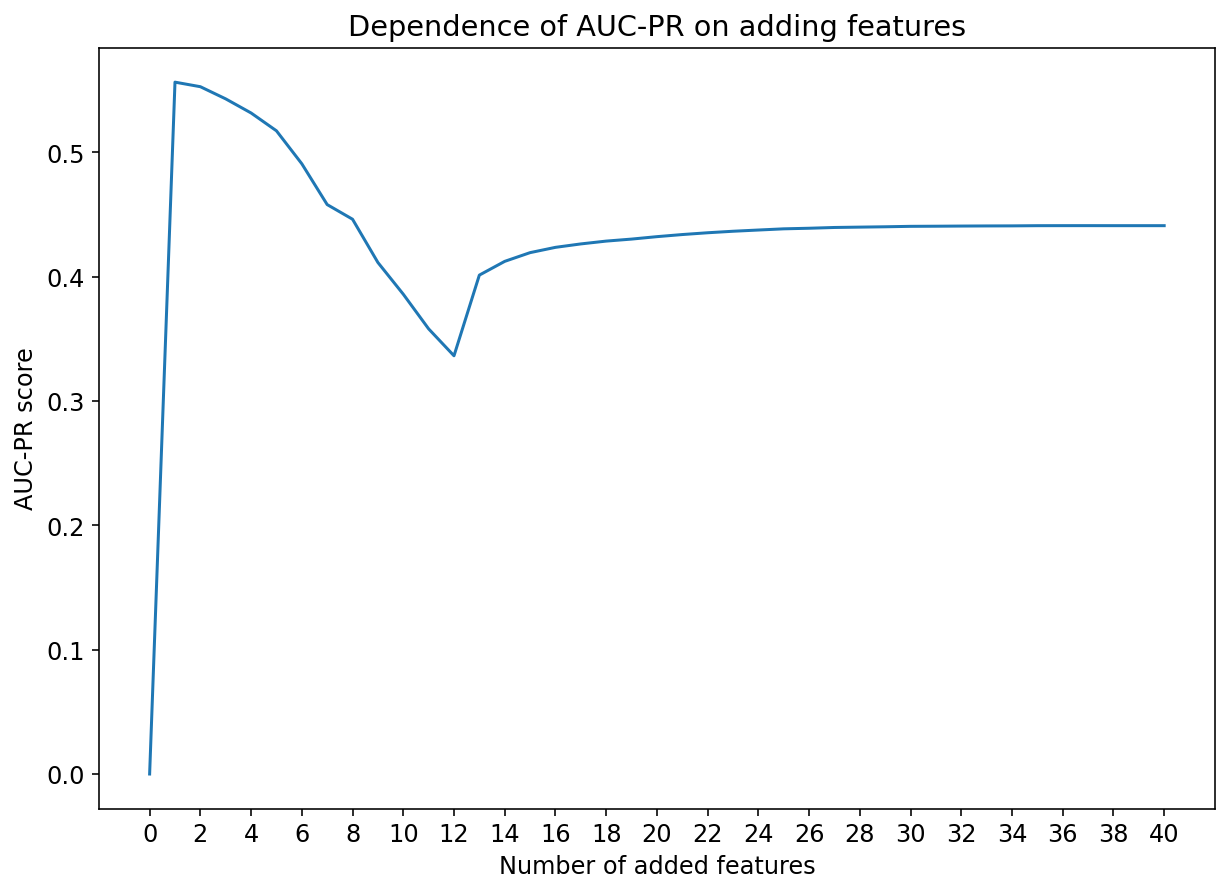

In [254]:
plt.plot(np.arange(0, len(auc_pr_best), 1), auc_pr_best)
plt.xticks(np.arange(0, len(auc_pr_best), 2))
plt.xlabel("Number of added features")
plt.ylabel("AUC-PR score")
plt.title('Dependence of AUC-PR on adding features')
plt.show()

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
1. Метод "Добавление признаков по одному"
* (+) Для начала хочу отметить очень интересную особенность, связанную с этим методом. График 'Dependence of AUC-PR on adding features' четко видно, что максимальное значение метрики AUC-PR достигается при наличии всего лишь одного признака - `default_yes`. Интересно здесь то, что такое значение достигается не только на валидационной выорке, но и на тестовой - то есть речь вряд ли идет о переобучении. Важно уточнить, что данные для графика получены с помощью подбора **без проверки условия на положительное приращение метрики**. Дело в том, что если оставить условие (в ячейке оно именно оставлено, поэтому она отработана не до конца и остановлен после неудачной попытки добавить второй признак - с добавлением любого второго метрика только ухудшается), алгорим будет останавливаться, так как для любого количества признаков выше 1, значение метрики будет хуже (это четко видно на графике).
* (+) Как уже сказано ранее, добавление признаков по одному дало лучший результат по значению метрики `AUC-PR`.
* (+) Данный метод позволяет выделять наиболее значимые признаки, а также признаки, которые мешают 
* (-) Несмотря на очевидные плюсы данного метода, он обладает и минусами. Его достаточно непросто реализовать (по сравнению с другими методами), а также он один из самых затратных по времени.

2. Метод "Удаление признаков по одному"
* (+) По этому методу чень легко отслеживать значимость признаков, выделять наименее значимые, а также смотреть, как ведет себя метрика в зависимости от количества признаков
* (+) Если не ограничиваться нужным количеством признаков, можно, благодаря условию на приращение значения метрики, выбросить все признаки, мешающие классификатору работать хорошо.
* (-) "Удаление признаков по одному" достаточно тяжело реализовать
* (-) Данный метод оказался наиболее долгим - для перебора каждого из признаков на каждом шаге требуется заново обучать классификатор, причем начиная с максимального количества признаков (а не с одного, как в предыдущем методе), и это занимает много времени.


3. Метод "Фильтрация"
* (+) Один из самых полнятных методов
* (+) Очень легко и очень быстро реализуется, требует минимальных усилий
* (+-) Дает неплохой результат, но, по сравнению с первым методом, недостаточно хороший.

4. Метод "Отбор по значениям w"
* (+) Легко и интуитивно понятно реализуется, не надо дополнительно разбираться в формулах, чтобы понять, как метод работает.
* (+) На нем интересно отсматривать, как масштабирование влияет на отбор признаков, и как отбор после масштабирования разных признаков отражается на качестве.
* (-) Не дает хорошего резульатата
* (-) Не позволяет оценить вклад каждого признака по-отдельности, показывает только важность признаков, когда они в совокупности - а вместе они, как было выяснено ранее, раюотаю не так хорошо.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
#your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [ ]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Я завтракала моей любимой овсяной кашей с курагой - это пища богов!!!

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ Так, ну мы обсудили миграцию студентов пермской Вышки в Москву и Питер, немного поговорили про наши впечатления о домашках и самостоятельных, обсудили, кто с какой ОП. Да и так просто болтали обо всем))

![Zoom_meeting](bonus_4.png)

## Ссылки:
* [визуализация SVC](https://medium.com/geekculture/svm-classification-with-sklearn-svm-svc-how-to-plot-a-decision-boundary-with-margins-in-2d-space-7232cb3962c0)
* [визуализация разделяющей прямой в LR](https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression)